This kernel adopted the idea of [Miguel Angel](https://www.kaggle.com/miguelangelnieto/house-prices-advanced-regression-techniques/pca-and-regression) and further develop based on the data exploration.

The steps are:
1. Feature reduction with PCA
2. Data transformation (log, hot encoding, nan)
3. Test different regression models

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

from sklearn import linear_model
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load data

In [3]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

data = pd.concat([train, test], ignore_index=True)
data = data.drop('SalePrice', 1)

labels = train['SalePrice']
ids = test['Id']

In [3]:
for i in list(train):
    if i not in list(data):
        print(i)

SalePrice


In [4]:
# Count the number of NaNs each column has.
nans=pd.isnull(data).sum()
nans[nans>0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

# Data preprocessing

## Remove columns with missing value

In [5]:
remove_columns = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
Garage_variables = ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt']
Msmt_variables = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']

In [6]:
data = data.drop(remove_columns, 1)

In [7]:
data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BldgType',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fireplaces',
       'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
       'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea',
       'LotConfig', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscVal', 'MoSold', 'Neighborhood',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'ScreenPorch',
       'St

## One hot encode

In [8]:
all_columns = data.columns.values

In [9]:
non_categorical = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
                   "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
                   "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
                   "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
                   "ScreenPorch","PoolArea", "MiscVal"]

categorical = [value for value in all_columns if value not in non_categorical]

In [10]:
# One Hot Encoding and nan transformation
data = pd.get_dummies(data)

In [11]:
data['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40, 150])

## Impute missing data

In [12]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data = imp.fit_transform(data)

In [13]:
data

array([[  8.56000000e+02,   8.54000000e+02,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.26200000e+03,   0.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  9.20000000e+02,   8.66000000e+02,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.22400000e+03,   0.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  9.70000000e+02,   0.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  9.96000000e+02,   1.00400000e+03,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00]])

## Log transformation

In [14]:
# Log transformation
data = np.log(data)
labels = np.log(labels)

# Change -inf to 0 again
data[data==-np.inf]=0

## Feature selection

In [15]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([ 0.22510507,  0.40354233,  0.52569112,  0.62615666,  0.69727311,
        0.76093533,  0.8131376 ,  0.85802706,  0.89342756,  0.92423378,
        0.95052401,  0.9597892 ,  0.96728592,  0.97458524,  0.98050966,
        0.98581876,  0.98993944,  0.99274785,  0.99456931,  0.99591184,
        0.99679368,  0.99759217,  0.99831226,  0.99883728,  0.99923615,
        0.99950169,  0.99968656,  0.99981229,  0.99989253,  0.99995069,
        0.99999662,  0.99999873,  0.99999945,  0.99999999,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [16]:
pca = PCA(n_components=36,whiten=True)
pca = pca.fit(data)
dataPCA = pca.transform(data)

# Model selection

Here, it'd better to test the goodness of models by using cross validation

In [17]:
def modelTest(clf, train, labels):
    cv = KFold(n_splits=5,shuffle=True,random_state=45).split(train)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=r2)
    scores=[r2_val_score.mean()]
    return scores

In [18]:
def modelPlot(result_dict):
    result = pd.DataFrame.from_dict(result_dict, orient='index')
    result.columns = ["R Square Score"] 
    result = result.sort(columns=["R Square Score"],ascending=False)
    #print(result)
    result.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return result

In [19]:
def modelFit(train, labels):
    result_dict = {}
    
    clf = linear_model.LinearRegression()
    result_dict["Linear"] = modelTest(clf, train, labels)
    
    clf = linear_model.Lasso(alpha=1e-4)
    result_dict["Lasso"] = modelTest(clf, train, labels)
    
    clf = linear_model.Ridge()
    result_dict["Ridge"] = modelTest(clf, train, labels)
    
    clf = linear_model.BayesianRidge()
    result_dict["Bayesian Ridge"] = modelTest(clf, train, labels)
    
    clf = linear_model.HuberRegressor()
    result_dict["Huber"] = modelTest(clf, train, labels)
    
    clf = svm.SVR()
    result_dict["SVM RBF"] = modelTest(clf, train, labels)
    
    clf = svm.SVR(kernel="linear")
    result_dict["SVM Linear"] = modelTest(clf, train, labels)
    
    clf = BaggingRegressor()
    result_dict["Bagging"] = modelTest(clf, train, labels)
    
    clf = RandomForestRegressor()
    result_dict["RandomForest"] = modelTest(clf, train, labels)
    
    clf = AdaBoostRegressor()
    result_dict["AdaBoost"] = modelTest(clf, train, labels)
    
    clf = XGBRegressor()
    result_dict["XGBoost"] = modelTest(clf, train, labels)
    
    model_summary = modelPlot(result_dict)
    return model_summary

## Before PCA

In [20]:
# Split traing and test
train = data[:1460]
test = data[1460:]

,R Square Score
XGBoost,0.877809
Lasso,0.854601
Linear,0.854575
Bayesian Ridge,0.853279
SVM Linear,0.849482
Bagging,0.845765
RandomForest,0.841620
Ridge,0.839074
Huber,0.835650
SVM RBF,0.813648


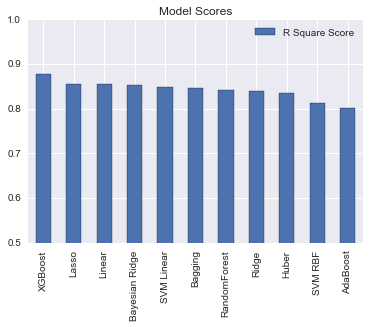

In [21]:
modelFit(train,labels)

## After PCA

In [22]:
train_pca = dataPCA[:1460]
test_pca = dataPCA[1460:]

,R Square Score
Huber,0.859954
SVM Linear,0.858995
Bayesian Ridge,0.854698
Lasso,0.854663
Ridge,0.854611
Linear,0.854575
XGBoost,0.801433
SVM RBF,0.797962
RandomForest,0.722898
Bagging,0.714236


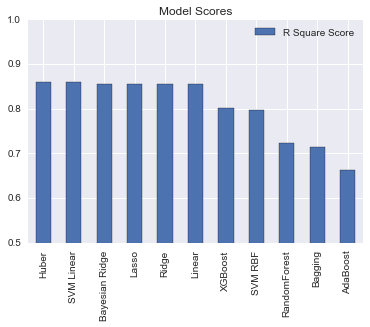

In [23]:
modelFit(train_pca, labels)

# Run model

R-squared is the “percent of variance explained” by the mode. Therefore, the bigger r2, the better the model. 

Let's try to run Huber and XGBoost, which may be potential candidates!!!

**Steps:**
- Hyperparameters tuning
- Model fitting

In [24]:
def hyperparaTuning(clf, train, labels, param_grid):
    cv = KFold(n_splits=5,shuffle=True,random_state=45)
    score = make_scorer(r2_score)
    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring=score)
    grid_search.fit(train, labels)
    return grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

## Huber Regressor

In [25]:
param_grid = {'alpha': [1000,100,10, 1],
              'epsilon' : [1.2,1.25,1.50],
              'tol' : [1e-10, 1e-9]}

hr = linear_model.HuberRegressor()
hyperparaTuning(hr, train, labels, param_grid)

([mean: 0.74017, std: 0.05391, params: {'tol': 1e-10, 'alpha': 1000, 'epsilon': 1.2},
  mean: 0.74017, std: 0.05391, params: {'tol': 1e-09, 'alpha': 1000, 'epsilon': 1.2},
  mean: 0.75015, std: 0.04004, params: {'tol': 1e-10, 'alpha': 1000, 'epsilon': 1.25},
  mean: 0.75015, std: 0.04004, params: {'tol': 1e-09, 'alpha': 1000, 'epsilon': 1.25},
  mean: 0.76011, std: 0.05533, params: {'tol': 1e-10, 'alpha': 1000, 'epsilon': 1.5},
  mean: 0.76011, std: 0.05533, params: {'tol': 1e-09, 'alpha': 1000, 'epsilon': 1.5},
  mean: 0.83009, std: 0.04603, params: {'tol': 1e-10, 'alpha': 100, 'epsilon': 1.2},
  mean: 0.83009, std: 0.04603, params: {'tol': 1e-09, 'alpha': 100, 'epsilon': 1.2},
  mean: 0.83158, std: 0.04605, params: {'tol': 1e-10, 'alpha': 100, 'epsilon': 1.25},
  mean: 0.83158, std: 0.04605, params: {'tol': 1e-09, 'alpha': 100, 'epsilon': 1.25},
  mean: 0.83304, std: 0.04512, params: {'tol': 1e-10, 'alpha': 100, 'epsilon': 1.5},
  mean: 0.83304, std: 0.04512, params: {'tol': 1e-09, '

## XGBoost

In [26]:
"""
param_grid = [{"max_depth": [3, 5, 7, 9],
               "min_child_weight": [1, 3, 5]}]

xgb = XGBRegressor(learning_rate=0.1, n_estimators=103, gamma=0, 
                   subsample=0.8, colsample_bytree=0.8, reg_alpha=0, 
                   reg_lambda=1, objective="reg:linear")
hyperparaTuning(xgb, train, labels, param_grid)
"""

'\nparam_grid = [{"max_depth": [3, 5, 7, 9],\n               "min_child_weight": [1, 3, 5]}]\n\nxgb = XGBRegressor(learning_rate=0.1, n_estimators=103, gamma=0, \n                   subsample=0.8, colsample_bytree=0.8, reg_alpha=0, \n                   reg_lambda=1, objective="reg:linear")\nhyperparaTuning(xgb, train, labels, param_grid)\n'

## Neural network

# Save prediction

In [3]:
def modelSubmit(model, train_data, train_label, test_data, name):
    model.fit(train_data, train_label)
    ln_pred = model.predict(test_data)
    pred = np.exp(ln_pred)
    submission = pd.DataFrame({"Id": ids, "SalePrice": pred})
    filename = os.path.join(name + ".csv")
    submission.to_csv('submit/' + filename, index=False)

In [42]:
hrfinal = linear_model.HuberRegressor(alpha=1, epsilon=1.5, fit_intercept=True, max_iter=100,
             tol=1e-10, warm_start=False)

In [28]:
xgbfinal = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
            gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
            min_child_weight=1, missing=None, n_estimators=103, nthread=-1,
            objective='reg:linear', reg_alpha=0, reg_lambda=1,
            scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [49]:
modelSubmit(xgbfinal, train, labels, test)

In [45]:
modelSubmit(hrfinal, train, labels, test)